# Pachon DIMM data note 1 figures

## jupyter boilerplate

Imports of python modules I usually want when working a a jupyter notebook.

In [1]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import sys
import os
from collections import namedtuple, OrderedDict
from functools import partial
from datetime import datetime, timedelta
import calendar

import astropy
import astropy.coordinates
import astropy.units as u
from astropy.coordinates import EarthLocation, get_sun, AltAz
import psycopg2
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import healpy
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipywidgets as widgets
from mpl_toolkits.basemap import Basemap
# importing easyaccess resets some pandas parameters to unfortunate values
pd.options.display.max_rows = 10

import sqlite3

import statsmodels.graphics.tsaplots
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from scipy.stats import anderson_ksamp
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.optimize import curve_fit
from statsmodels.formula.api import ols as formula_ols

mpl.rcParams['figure.figsize'] = (8, 5)
plt.style.use('ggplot')
np.random.seed(6563)


## Load the Pachon DIMM data

The data from the DIMM Pachon loaded here was provided to me by Edison Bustos in email on 2018-03-21. It contains time stamps and seeing estimates from Pachon DIMM data. These estimates arise from an equation that assumes Kolmogorov seeing, and are calculated for a wavelongth of 500nm. See equation 5 of Tokovinin 2002 (2002PASP..114.1156T).

### Read the raw data

The email included two separate files with diffirent date ranges. Read both and merge them.

In [207]:
dimm_old = pd.read_table('/data/des70.a/data/neilsen/obs_strat/data/pachon.Pachon_seeing-2004-2016.txt.bz2', sep="\t", parse_dates=[0])
dimm_old.drop('meandx', axis=1, inplace=True)
dimm_old.columns = ['time', 'seeing']
dimm_new = pd.read_table('/data/des70.a/data/neilsen/obs_strat/data/PachonSM.DIMM-2016-2018.txt.bz2', sep="\t", parse_dates=[0])
dimm = pd.concat([dimm_old, dimm_new])
dimm.sort_values('time', ascending=True, inplace=True)
dimm.set_index('time', inplace=True)
dimm = dimm.groupby(level=0).mean()
dimm = dimm.tz_localize('UTC')
dimm.head()

/data/des70.a/data/neilsen/anaconda/envs/ehn37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.
/data/des70.a/data/neilsen/anaconda/envs/ehn37/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead.
  after removing the cwd from sys.path.


,seeing
time,
2004-03-17 02:33:15+00:00,0.71
2004-03-17 02:34:35+00:00,0.74
2004-03-17 02:35:42+00:00,0.74
2004-03-17 02:36:49+00:00,0.75
2004-03-17 02:37:58+00:00,0.72


### Filter out unreasonable values

In [208]:
dimm.query('(seeing < 5) & (seeing > 0.1)', inplace=True)

/data/des70.a/data/neilsen/anaconda/envs/ehn37/lib/python3.7/site-packages/pandas/core/generic.py:407: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  s = level_values.to_series()
/data/des70.a/data/neilsen/anaconda/envs/ehn37/lib/python3.7/site-packages/pandas/core/generic.py:415: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  dindex = axis_index.to_series()


### Calculate $r_{0}$

Rather than use the seeing estimate from the Kolmogorov-derived equation, use the Fried paramater.

In [209]:
dimm['r0'] = 0.98*5e-7/np.radians(dimm.seeing/(60*60))
dimm['log_r0'] = np.log10(dimm.r0)

### Calculate von Karman seeing

Tokovinin 2002 provides an equation (eqn 19) that approximates the seeing for a given Fried paramater assuming a von Karman model. This model requires an estime of the outer scale of the seeing, $L_0$. A value for $L_0$ is poorly known; the only estimate I can find is from Ziad et al 2000 (2000ApOpt..39.5415Z), which gives a value of 28.4 -13.3/+25.0 meters. I will use a value of 30 meters.

In [210]:
def calc_FWHM_vK(fwhm_dimm, outer_scale=30, wavelength=5.0e-7):
    r0 = 0.98*wavelength/(np.radians(fwhm_dimm/(60*60)))
    # fwhm = fwhm_dimm * np.sqrt(1.0 - 2.813*np.power(r0/outer_scale, 0.356) ) #oops!
    fwhm = fwhm_dimm * np.sqrt(1.0 - 2.183*np.power(r0/outer_scale, 0.356) )
    return fwhm

dimm['vk_seeing'] = calc_FWHM_vK(dimm.seeing, 30)

In [211]:
dimm.describe()

,seeing,r0,log_r0,vk_seeing
count,1.1604340e+06,1.1604340e+06,1.1604340e+06,1.1604340e+06
mean,8.8341319e-01,1.2862406e-01,-9.1483300e-01,7.4082547e-01
std,3.4318068e-01,4.2932562e-02,1.4800702e-01,3.1165831e-01
min,1.0100000e-01,2.0389299e-02,-1.6905977e+00,5.9702287e-02
25%,6.6000000e-01,9.9185236e-02,-1.0035530e+00,5.3882341e-01
50%,8.1000000e-01,1.2477748e-01,-9.0386381e-01,6.7281518e-01
75%,1.0190000e+00,1.5313599e-01,-8.1492272e-01,8.6121149e-01
max,4.9570000e+00,1.0006906e+00,2.9983942e-04,4.5359005e+00


### Plot the time series

First, set some date columns to make plotting more convenient.

In [212]:
dimm['month'] = dimm.index.month
dimm['year'] = dimm.index.year
dimm['data_month'] = 12*(dimm.year - np.min(dimm.year)) + dimm.month
dimm['mjd'] = dimm.index.to_julian_date() - 2400000.5

# Pachon is at a longitude of 70.8062
# night is like mjd, but shifts the rollover to be local solar noon
ctio_night_shift = (180.0-70.8062)/360.0
dimm['night'] = np.floor(dimm.mjd + ctio_night_shift).astype(int)

I'll start by just plotting the time series, averaged by month. 

I plot include a [lowess](https://en.wikipedia.org/wiki/Local_regression) smoothed curved through the points, which just estimates a smooth function by doing linear fits to nearby points.

/data/des70.a/data/neilsen/anaconda/envs/ehn37/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f8a98bbc828> has a label of '_no_label_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/data/des70.a/data/neilsen/anaconda/envs/ehn37/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f8a98bbc8d0> has a label of '_no_label_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


Text(0, 0.5, 'FWHM (asec)')

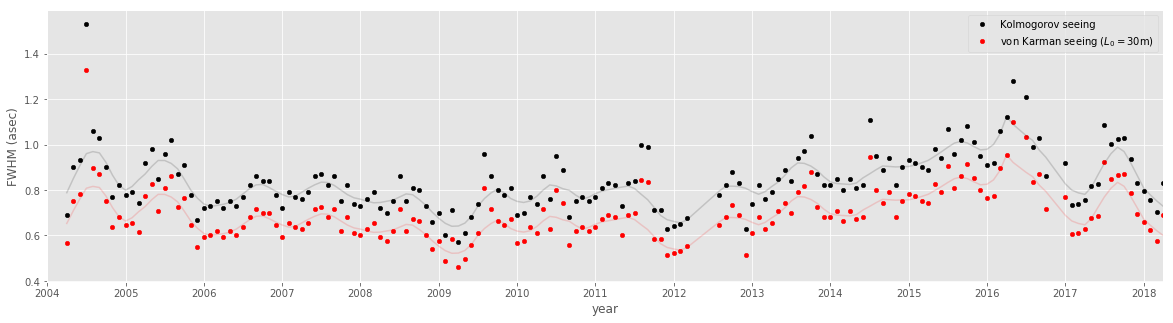

In [213]:
mpl.rcParams['figure.figsize'] = (20, 5)
fig, axes = plt.subplots()

df = dimm.groupby('data_month').agg({'seeing': 'median', 'vk_seeing': 'median'}).reset_index()
df.plot.scatter('data_month', 'seeing', color='black', label='Kolmogorov seeing', ax=axes)
df.plot.scatter('data_month', 'vk_seeing', color='red', label='von Karman seeing ($L_0=30$m)', ax=axes)

df['seeing_lowess'] = lowess(df.seeing, df.data_month, frac=0.05).T[1]
df.plot('data_month', 'seeing_lowess', color='black', alpha=0.15, label='_no_label_', ax=axes)
df['vk_seeing_lowess'] = lowess(df.vk_seeing, df.data_month, frac=0.05).T[1]
df.plot('data_month', 'vk_seeing_lowess', color='red', alpha=0.15, label='_no_label_', ax=axes)

month_ticks = np.arange(0, 180, 12)
axes.set_xticks(month_ticks)
axes.set_xticklabels(np.min(dimm.year) + (month_ticks/12).astype(int))
axes.set_xlabel('year')
axes.set_ylabel('FWHM (asec)')

Text(0, 0.5, 'FWHM (asec)')

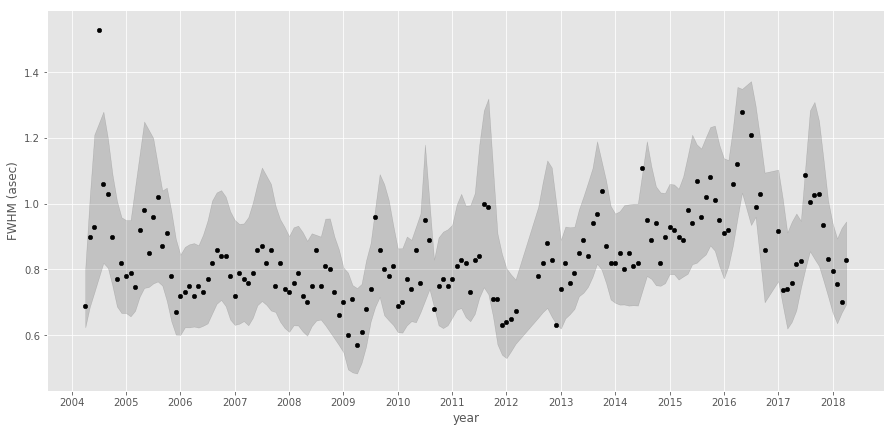

In [214]:
mpl.rcParams['figure.figsize'] = (15, 7)
fig, axes = plt.subplots()

df = dimm.groupby('data_month')[['seeing', 'vk_seeing']].describe().reset_index()
df.plot.scatter('data_month', ('seeing', '50%'), color='black', label='Kolmogorov seeing', ax=axes, legend=False)

frac = 6.0/(12*(2018-2004))
df[('seeing', 'lowess_25')] = lowess(df[('seeing', '25%')], df.data_month, frac=frac).T[1]
df[('seeing', 'lowess_75')] = lowess(df[('seeing', '75%')], df.data_month, frac=frac).T[1]
#df.plot('data_month', ('seeing', 'lowess_25'), color='black', alpha=0.15, label='_no_label_', ax=axes)
#df.plot('data_month', ('seeing', 'lowess_75'), color='black', alpha=0.15, label='_no_label_', ax=axes)

axes.fill_between(df['data_month'], df[('seeing', 'lowess_25')], df[('seeing', 'lowess_75')], color='black', alpha=0.15, label='_no_label_')

month_ticks = np.arange(0, 180, 12)
axes.set_xticks(month_ticks)
axes.set_xticklabels(np.min(dimm.year) + (month_ticks/12).astype(int))
axes.set_xlabel('year')
axes.set_ylabel('FWHM (asec)')

Text(0.5, 0, 'lag (years)')

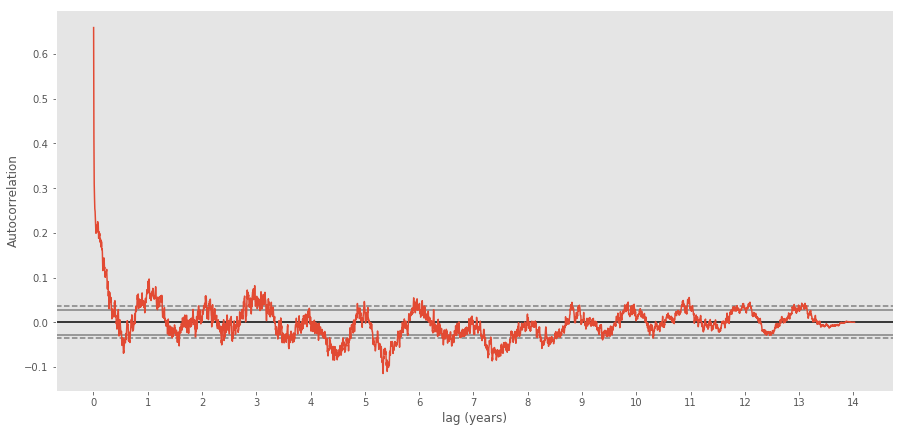

In [215]:
#mpl.rcParams['figure.figsize'] = (8, 5)
mpl.rcParams['figure.figsize'] = (15, 7)
fig, axes = plt.subplots()
df = pd.DataFrame({'night': np.arange(dimm.night.min(), dimm.night.max()), 'dummy': 0}).set_index('night')
df['log_r0'] = dimm.groupby('night')['log_r0'].mean().copy()
df.log_r0.fillna(method='ffill', inplace=True)
pd.plotting.autocorrelation_plot(df.log_r0, ax=axes)
axes.set_xticks(np.arange(0, dimm.night.max()-dimm.night.min(),365))
axes.set_xticklabels(np.arange(0, 15))
axes.set_xlabel('lag (years)')

Text(0.5, 0, 'lag (years)')

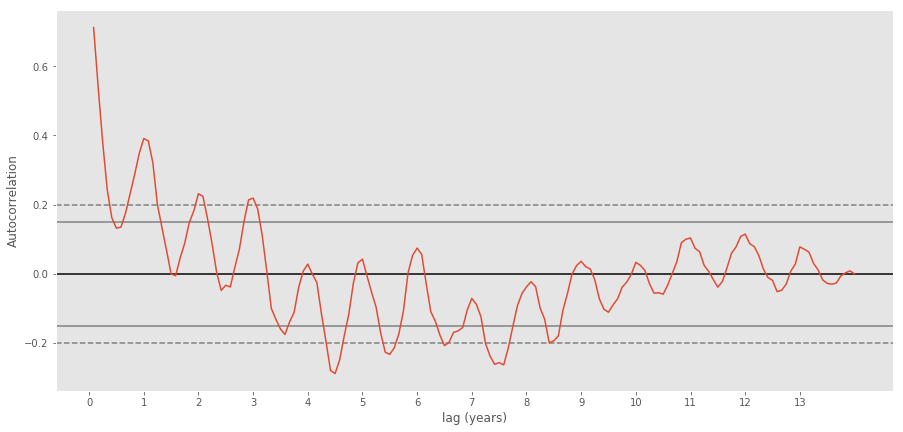

In [216]:
#mpl.rcParams['figure.figsize'] = (8, 5)
mpl.rcParams['figure.figsize'] = (15, 7)
fig, axes = plt.subplots()
df = pd.DataFrame({'data_month': np.arange(dimm.data_month.min(), dimm.data_month.max()), 'dummy': 0}).set_index('data_month')
df['log_r0'] = dimm.groupby('data_month')['log_r0'].mean().copy()
df.log_r0.fillna(method='ffill', inplace=True)
pd.plotting.autocorrelation_plot(df.log_r0, ax=axes)
axes.set_xticks(np.arange(0, dimm.data_month.max()-dimm.data_month.min(),12))
axes.set_xticklabels(np.arange(0, 15*12))
axes.set_xlabel('lag (years)')

In [12]:
df.head()

,dummy,log_r0
data_month,,
3,0,-0.841452
4,0,-0.945263
5,0,-0.978854
6,0,-1.138275
7,0,-0.998271


In [13]:
dimm.groupby('data_month')[['seeing', 'vk_seeing']].describe().reset_index()

data_month   seeing                                                   \
                  count      mean       std    min    25%    50%     75%   
0            3   2137.0  0.717197  0.163331  0.420  0.610  0.690  0.7800   
1            4   7188.0  0.929688  0.274845  0.370  0.720  0.900  1.1000   
2            5   9834.0  1.027387  0.397657  0.300  0.730  0.930  1.2100   
3            6   4534.0  1.513485  0.579219  0.350  1.040  1.530  1.9600   
4            7   7688.0  1.065585  0.347437  0.320  0.820  1.060  1.2800   
..         ...      ...       ...       ...    ...    ...    ...     ...   
157        167  10147.0  0.862433  0.252448  0.349  0.687  0.833  0.9775   
158        168  13326.0  0.847086  0.249052  0.342  0.680  0.795  0.9430   
159        169  11507.0  0.781284  0.210946  0.281  0.634  0.755  0.9020   
160        170  11657.0  0.726354  0.203915  0.257  0.597  0.702  0.8160   
161        171  11211.0  0.854855  0.201576  0.441  0.714  0.830  0.9660   

           vk_seeing                                                    \
       max     count      mean       std       min       25%       50%   
0    1.980    2137.0  0.590416  0.146709  0.327570  0.494447  0.565524   
1    3.200    7188.0  0.781891  0.248502  0.284252  0.592276  0.753731   
2    3.340    9834.0  0.871148  0.362202  0.224187  0.601204  0.780777   
3    3.540    4534.0  1.315868  0.530716  0.267016  0.880231  1.327467   
4    2.870    7688.0  0.905384  0.315072  0.241270  0.681788  0.898358   
..     ...       ...       ...       ...       ...       ...       ...   
157  3.090   10147.0  0.721153  0.228105  0.266155  0.562851  0.693460   
158  3.187   13326.0  0.707296  0.225310  0.260137  0.556618  0.659364   
159  2.748   11507.0  0.648113  0.189428  0.208023  0.515728  0.623548   
160  2.529   11657.0  0.598949  0.183182  0.187705  0.482936  0.576218   
161  2.137   11211.0  0.713931  0.181704  0.345850  0.586921  0.690766   

                         
          75%       max  
0    0.645924  1.742463  
1    0.934650  2.879800  
2    1.034699  3.011124  
3    1.723953  3.198954  
4    1.098537  2.570817  
..        ...       ...  
157  0.823670  2.776714  
158  0.792508  2.867613  
159  0.755533  2.456806  
160  0.678198  2.252478  
161  0.813278  1.887953  

[162 rows x 17 columns]

Make a similar plot for the Fried parameter:

/data/des70.a/data/neilsen/anaconda/envs/ehn37/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f8b9965d5f8> has a label of '_no_label_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


Text(0, 0.5, 'Fried parameter $r_0$ (meters)')

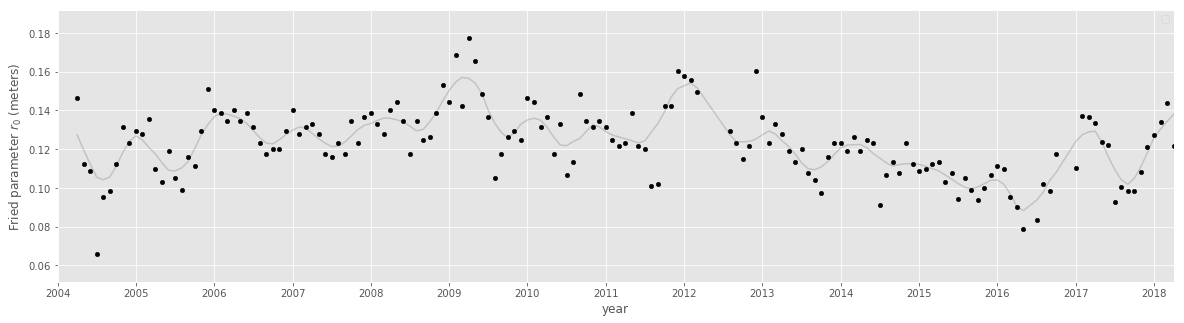

In [14]:
mpl.rcParams['figure.figsize'] = (20, 5)
fig, axes = plt.subplots()

df = dimm.groupby('data_month').agg({'r0': 'median'}).reset_index()
df.plot.scatter('data_month', 'r0', color='black', ax=axes)

df['r0_lowess'] = lowess(df.r0, df.data_month, frac=0.05).T[1]
df.plot('data_month', 'r0_lowess', color='black', alpha=0.15, label='_no_label_', ax=axes)

month_ticks = np.arange(0, 180, 12)
axes.set_xticks(month_ticks)
axes.set_xticklabels(np.min(dimm.year) + (month_ticks/12).astype(int))
axes.set_xlabel('year')
axes.set_ylabel('Fried parameter $r_0$ (meters)')

## Check the distributions for normality

The time series modeling I indend to do works best with data that are normally distributed. Check the distribution of data we actually have.

/data/des70.a/data/neilsen/anaconda/envs/ehn37/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/data/des70.a/data/neilsen/anaconda/envs/ehn37/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 0, '$\\log(r_0)$')

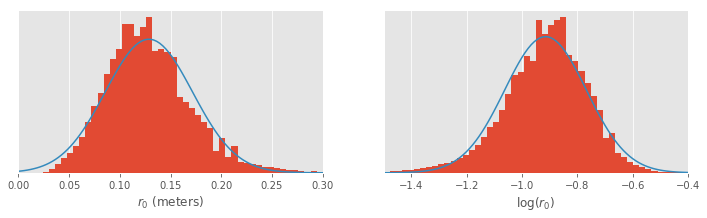

In [15]:
mpl.rcParams['figure.figsize'] = (12, 3)
fig, axes = plt.subplots(1,2)

dimm.r0.hist(bins=50, range=(0,0.3), normed=True, ax=axes[0])
r0_norm_fit = scipy.stats.norm.fit(dimm.r0)
x = np.linspace(0, 0.3, 100)
r0_fit = pd.DataFrame({'x': x,
                       'r0': scipy.stats.norm.pdf(x, loc=r0_norm_fit[0], scale=r0_norm_fit[1])})
r0_fit.plot('x', 'r0', ax=axes[0], legend=False)
#scipy.stats.probplot(dimm.r0, dist=scipy.stats.norm, plot=axes[1,0])


dimm.log_r0.hist(bins=50, range=(-1.5, -0.4), normed=True, ax=axes[1])

lr0_norm_fit = scipy.stats.norm.fit(dimm.log_r0)
x = np.linspace(-1.5, -0.4, 100)
lr0_fit = pd.DataFrame({'x': x,
                       'lr0': scipy.stats.norm.pdf(x, loc=lr0_norm_fit[0], scale=lr0_norm_fit[1])})
lr0_fit.plot('x', 'lr0', ax=axes[1], legend=False)

axes[0].set_yticks([])
axes[0].set_xlabel('$r_0$ (meters)')
#axes[0].set_xlim((0, 0.3))
axes[1].set_yticks([])
axes[1].set_xlabel('$\log(r_0)$')

#scipy.stats.probplot(dimm.log_r0, dist=scipy.stats.norm, plot=axes[1,1])

((array([-4.8565255 , -4.67779401, -4.58119483, ...,  4.58119483,
          4.67779401,  4.8565255 ]),
  array([-1.69059771e+00, -1.69042245e+00, -1.68778502e+00, ...,
         -3.67714720e-02, -3.67714720e-02,  2.99839422e-04])),
 (0.1470280671605353, -0.9148330016642388, 0.9933816685857009))

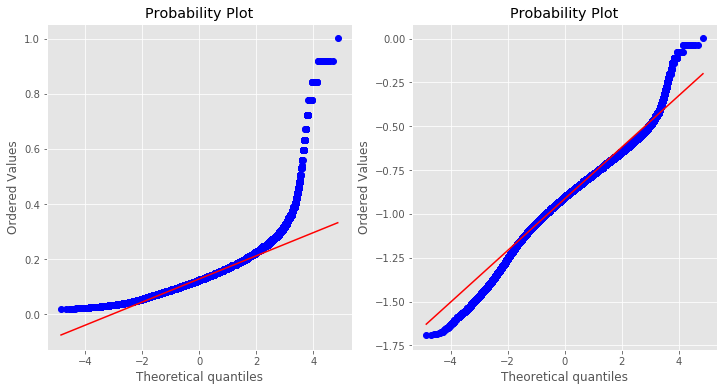

In [16]:
mpl.rcParams['figure.figsize'] = (12, 6)
fig, axes = plt.subplots(1,2)

scipy.stats.probplot(dimm.r0, dist=scipy.stats.norm, plot=axes[0])
scipy.stats.probplot(dimm.log_r0, dist=scipy.stats.norm, plot=axes[1])

In [17]:
print("Skewness:", scipy.stats.skew(dimm.log_r0))
print("Excess kurtosis:", scipy.stats.kurtosis(dimm.log_r0, fisher=True))

Skewness: -0.4456482467842725
Excess kurtosis: 0.8651605042314392


In [18]:
df = dimm
print(scipy.stats.normaltest(df.r0).pvalue, scipy.stats.normaltest(df.log_r0).pvalue)
print(scipy.stats.skewtest(df.r0).pvalue, scipy.stats.skewtest(df.log_r0).pvalue)
print(scipy.stats.kurtosistest(df.r0).pvalue, scipy.stats.kurtosistest(df.log_r0).pvalue)

0.0 0.0
0.0 0.0
0.0 0.0


In [19]:
df = dimm.sample(30000)
print(scipy.stats.normaltest(df.r0).pvalue, scipy.stats.normaltest(df.log_r0).pvalue)
print(scipy.stats.skewtest(df.r0).pvalue, scipy.stats.skewtest(df.log_r0).pvalue)
print(scipy.stats.kurtosistest(df.r0).pvalue, scipy.stats.kurtosistest(df.log_r0).pvalue)

0.0 0.0
0.0 2.5411377532013753e-212
0.0 6.854138880683504e-119


Okay, neither are really Gaussian, but $\log(r_{0})$ is closer to normal than $r_{0}$. One notable feature is the low-value tail of $log(r_0)$. This suggests that there is a poor-seeing tail of the distribution that my model will not be able to model well.

## Plot single night time series

In [20]:
def plot_night_seeing(df, night, fig, axes):
    night_df = df[df.night == night]
    
    night_df.plot(y='log_r0', drawstyle='steps-mid',ax=axes)

    # Add an axes with the DIMM measured seeing on the right
    right_axes = axes.twinx()
    night_df.plot(y='log_r0', drawstyle='steps-mid', ax=right_axes)

    seeing_ticks = np.concatenate((np.arange(0.4, 2.0, 0.2), np.arange(2.0, 4.0, 0.4)), axis=0)
    logr0_ticks = np.log10(0.98*5e-7/np.radians(seeing_ticks/(60*60)))
    right_axes.set_yticks(logr0_ticks)
    right_axes.set_yticklabels(seeing_ticks)
    right_axes.set_ylabel('seeing (")')

    right_axes.set_ylim(axes.get_ylim())
    right_axes.grid(False)
    axes.set_ylabel("$\log(r_{0})$, $r_{0}$ in meters")
    
    axes.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%m:%SZ'))
    
    axes.legend().set_visible(False)
    right_axes.legend().set_visible(False)
    
    axes.set_title('Night MJD %d' % night)
    return fig, axes

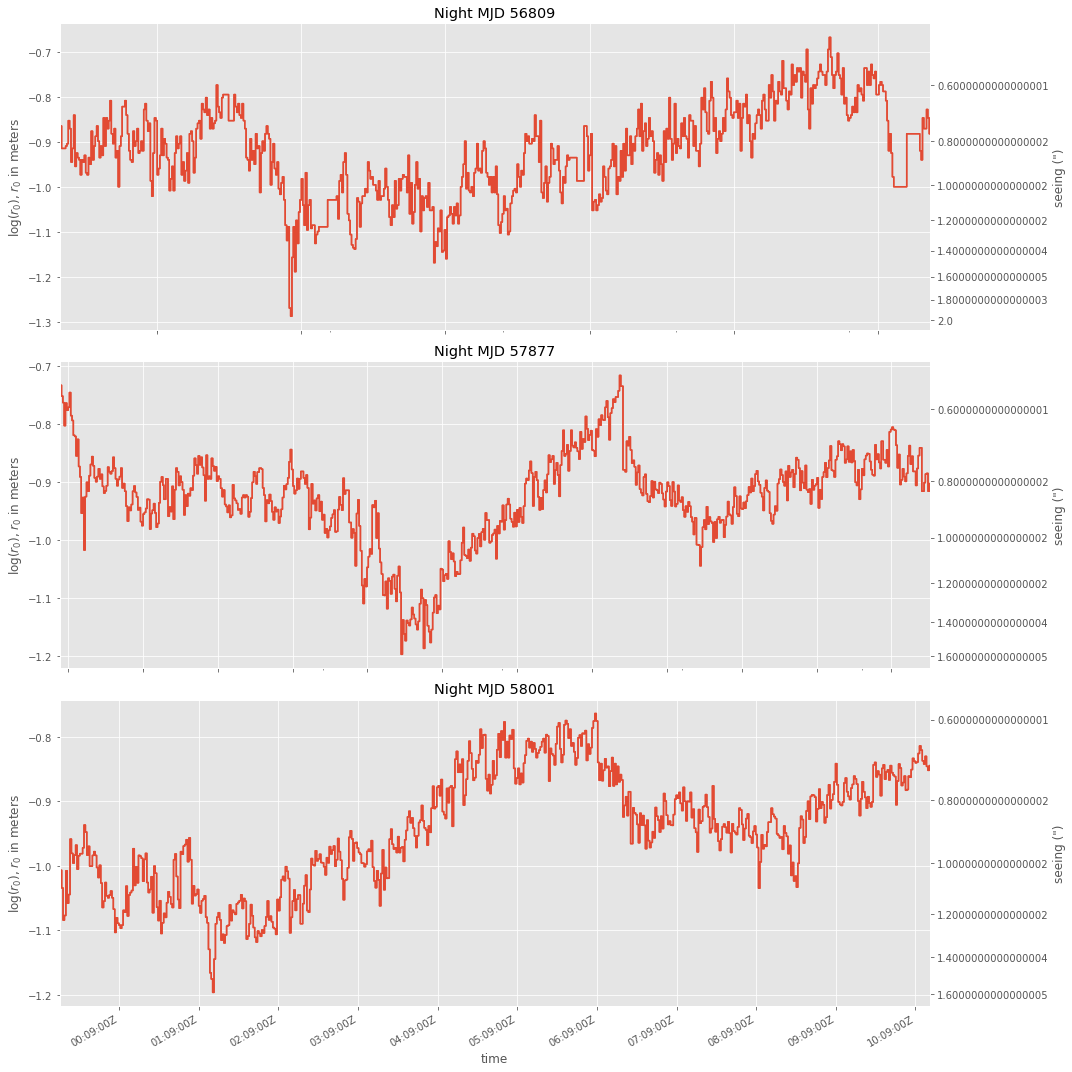

In [21]:
# Explicitly setting a seed make reproducability easier without having to rerun the whole notebook
np.random.seed(4861)

mpl.rcParams['figure.figsize'] = (15, 15)
fig, axes = plt.subplots(3,1)

# Pick some random nights during which the DIMM ran most of the night
sample_nights = dimm.groupby('night').agg({'seeing': 'count'}).query('seeing>600').sample(len(axes.flatten())).index.values
for ax, sample_night in zip(axes.flatten(), np.sort(sample_nights)):
    fig = plot_night_seeing(dimm, sample_night, fig, ax)
    
plt.tight_layout()

## Plot a year time series

In [22]:
def plot_year_seeing(df, year):
    irreg_year_df = df[df.year == year].groupby('night').agg({'log_r0': 'mean'})
        
    # Get a data frame with nights without data set to null
    # by creating a DataFrame with all nighths, then
    # assigning the log_r0 column into it, using pandas
    # index matching to match the rows appropriately
    first_mjd = (pd.to_datetime('%d-01-01' % year, format="%Y-%m-%d") 
                 - pd.to_datetime(2400000.5, unit='D', origin='julian')).days
    last_mjd = first_mjd + 367
    mjds = np.arange(irreg_year_df.index.values.min(), irreg_year_df.index.values.max())
    year_df = pd.DataFrame({'night': mjds,
                            'date': pd.to_datetime(mjds+2400000.5, unit='D', origin='julian')},
                           index=mjds)
    year_df['log_r0'] = irreg_year_df.log_r0
    
    mpl.rcParams['figure.figsize'] = (16, 10)
    fig, axes = plt.subplots()

    year_df.plot(y='log_r0', drawstyle='steps-mid', color='black', alpha=0.05, ax=axes)

    # Set x ticks
    axes.set_xticks(year_df[year_df.date.dt.day == 1].night)
    axes.set_xticklabels(year_df[year_df.date.dt.day == 1].date.dt.strftime('%Y-%m-%d'), rotation=45)
    
    # Add an axes with the DIMM measured seeing on the right
    right_axes = axes.twinx()
    year_df.reset_index().plot.scatter('night', 'log_r0', color='black', ax=right_axes)

    seeing_ticks = np.concatenate((np.arange(0.4, 2.0, 0.1), np.arange(2.0, 4.0, 0.2)), axis=0)
    logr0_ticks = np.log10(0.98*5e-7/np.radians(seeing_ticks/(60*60)))
    right_axes.set_yticks(logr0_ticks)
    right_axes.set_yticklabels(seeing_ticks)
    right_axes.set_ylabel("DIMM reported seeing (arcseconds)")
    
    right_axes.set_ylim(axes.get_ylim())
    right_axes.grid(False)
    axes.set_ylabel("$\log(r_{0})$, $r_{0}$ in meters")
    
    axes.legend().set_visible(False)
    right_axes.legend().set_visible(False)
    # axes.set_title("DIMM nightly means for %d" % year)
    axes.set_xlabel('Night')
    return fig

No handles with labels found to put in legend.


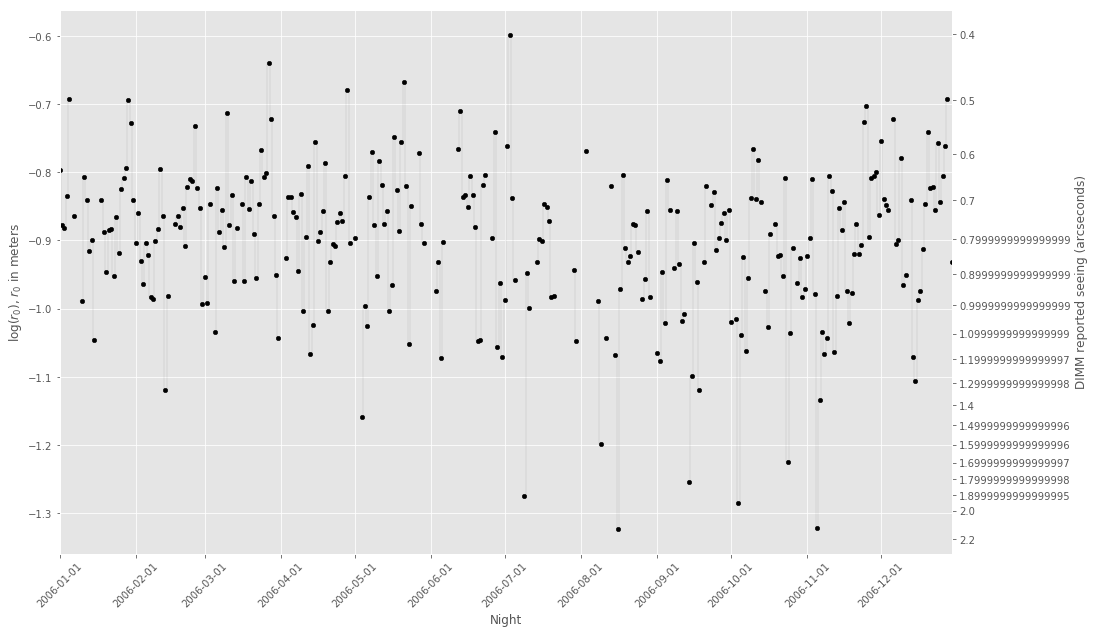

In [23]:
# Find the year with the least missing nights and plot it
year = dimm.groupby(['night', 'year']).agg({'seeing': 'mean'}).reset_index().groupby('year').agg({'night': 'count'}).sort_values('night', ascending=False).index.values[0]
fig = plot_year_seeing(dimm, year)

## Plot nightly means for all nights

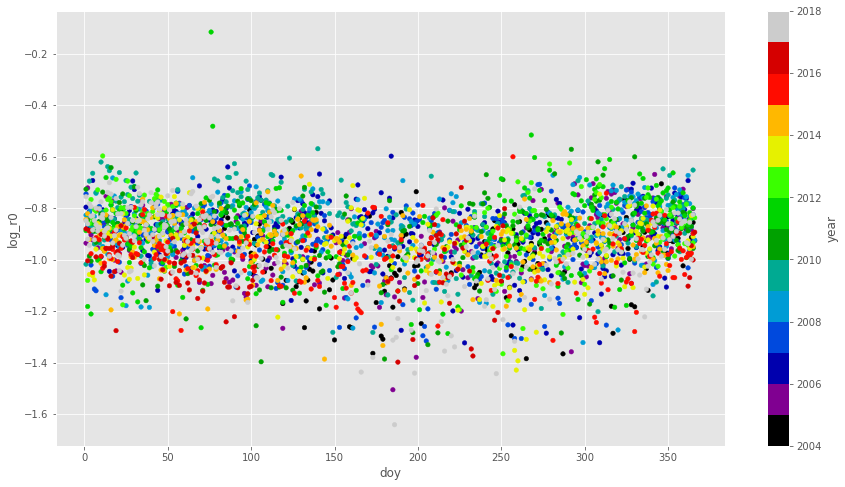

In [24]:
night_means = dimm.groupby('night').agg({'log_r0': 'mean', 'year': 'median'})
night_means['doy'] = pd.to_datetime(2400000.5+night_means.index.values, unit='D', origin='julian').dayofyear

mpl.rcParams['figure.figsize'] = (15, 8)
fig, axes = plt.subplots()

night_means.plot.scatter('doy', 'log_r0', c='year', colormap=mpl.cm.get_cmap('nipy_spectral', 14), ax=axes)


# von Karman model correction

In [25]:
def calc_FWHM_vK(fwhm_dimm, outer_scale=30, wavelength=5.0e-7):
    r0 = 0.98*wavelength/(np.radians(fwhm_dimm/(60*60)))
    fwhm = fwhm_dimm * np.sqrt(1.0 - 2.813*np.power(r0/outer_scale, 0.356) )
    return fwhm

print((0.83-calc_FWHM_vK(0.83, 30))/0.83)
print((0.83-calc_FWHM_vK(0.83, 28.4-13.3))/0.83)
print((0.83-calc_FWHM_vK(0.83, 28.4+25))/0.83)

0.2228683013894817
0.2969471525726199
0.17693612434979175


# El Nino

In [26]:
ocean = pd.read_csv('https://www.cpc.ncep.noaa.gov/data/indices/sstoi.indices', sep="\s+")
ocean.head()

,YR,MON,NINO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM.2,NINO3.4,ANOM.3
0,1982,1,24.29,-0.17,25.87,0.24,28.30,0.00,26.72,0.15
1,1982,2,25.49,-0.58,26.38,0.01,28.21,0.11,26.70,-0.02
2,1982,3,25.21,-1.31,26.98,-0.16,28.41,0.22,27.20,-0.02
3,1982,4,24.50,-0.97,27.68,0.18,28.92,0.42,28.02,0.24
4,1982,5,23.97,-0.23,27.79,0.71,29.49,0.70,28.54,0.69


In [27]:
ocean['year'] = ocean.YR + (ocean.MON+0.5)/12

Plot each month. Note that these are expected to be flat, because NOAA supplies the anomalies (differences from long term trends), not absolute values.

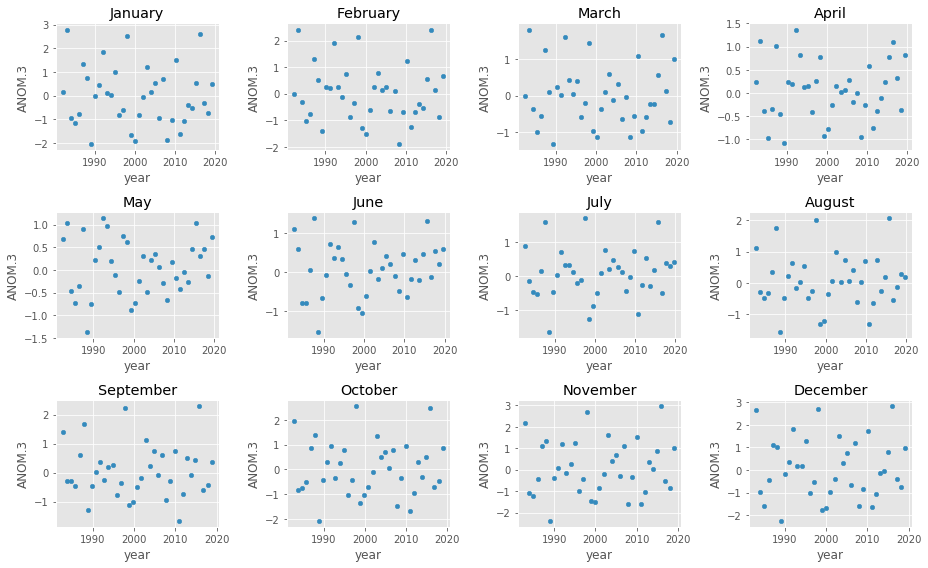

In [28]:
fig, axes = plt.subplots(3, 4, figsize=(13, 8))
for idx, ax in enumerate(axes.flatten()):
    month = idx + 1
    ocean[ocean.MON==month].plot.scatter('year', 'ANOM.3', ax=ax)
    ax.set_title(calendar.month_name[month])
plt.tight_layout()

In [29]:
ocean['dimm_month'] = (ocean.YR-2004)*12 + ocean.MON
ocean.set_index('dimm_month', drop=False, inplace=True)
ocean.head()

,YR,MON,NINO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM.2,NINO3.4,ANOM.3,year,dimm_month
dimm_month,,,,,,,,,,,,
-263,1982,1,24.29,-0.17,25.87,0.24,28.30,0.00,26.72,0.15,1982.125000,-263
-262,1982,2,25.49,-0.58,26.38,0.01,28.21,0.11,26.70,-0.02,1982.208333,-262
-261,1982,3,25.21,-1.31,26.98,-0.16,28.41,0.22,27.20,-0.02,1982.291667,-261
-260,1982,4,24.50,-0.97,27.68,0.18,28.92,0.42,28.02,0.24,1982.375000,-260
-259,1982,5,23.97,-0.23,27.79,0.71,29.49,0.70,28.54,0.69,1982.458333,-259


,data_month,seeing,vk_seeing,NINO12,NINO3,NINO34,NINO4
0,3,0.69,0.565524,25.94,27.16,27.10,28.43
1,4,0.90,0.753731,25.32,27.37,27.84,28.75
2,5,0.93,0.780777,23.05,26.72,28.06,29.16
3,6,1.53,1.327467,21.60,26.27,27.76,29.17
4,7,1.06,0.898358,20.71,25.41,27.69,29.39


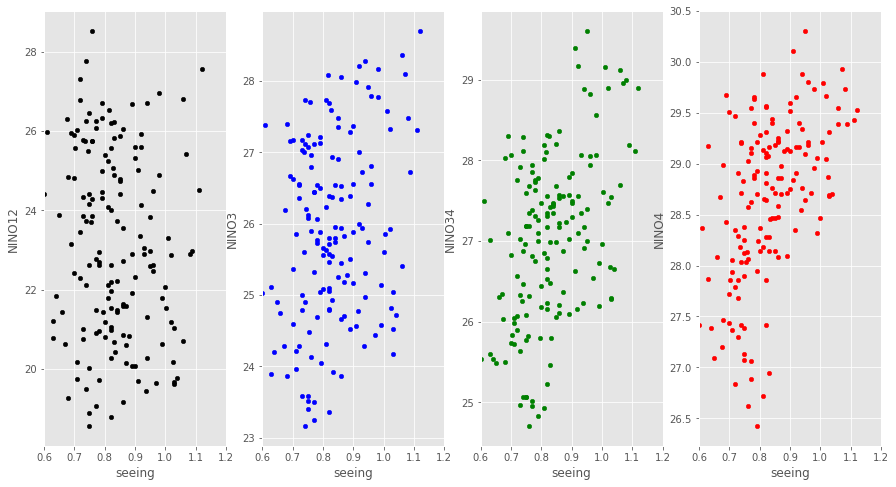

In [30]:
df = dimm.groupby('data_month').agg({'seeing': 'median', 'vk_seeing': 'median'})
df['NINO12'] = ocean['NINO1+2']
df['NINO3'] = ocean['NINO3']
df['NINO34'] = ocean['NINO3.4']
df['NINO4'] = ocean['NINO4']
df.reset_index(drop=False, inplace=True)
fig, ax = plt.subplots(1,4)
df.plot.scatter('seeing', 'NINO12', c='k', ax=ax[0])
df.plot.scatter('seeing', 'NINO3', ax=ax[1], c='b')
df.plot.scatter('seeing', 'NINO34', ax=ax[2], c='g')
df.plot.scatter('seeing', 'NINO4', ax=ax[3], c='r')
for a in ax:
    a.set_xlim(0.6, 1.2)
df.head()

The strongest correlation looks like NINO4, the westernmost: farthest from Chile!
See https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst/

Text(0, 0.5, 'FWHM (asec)')

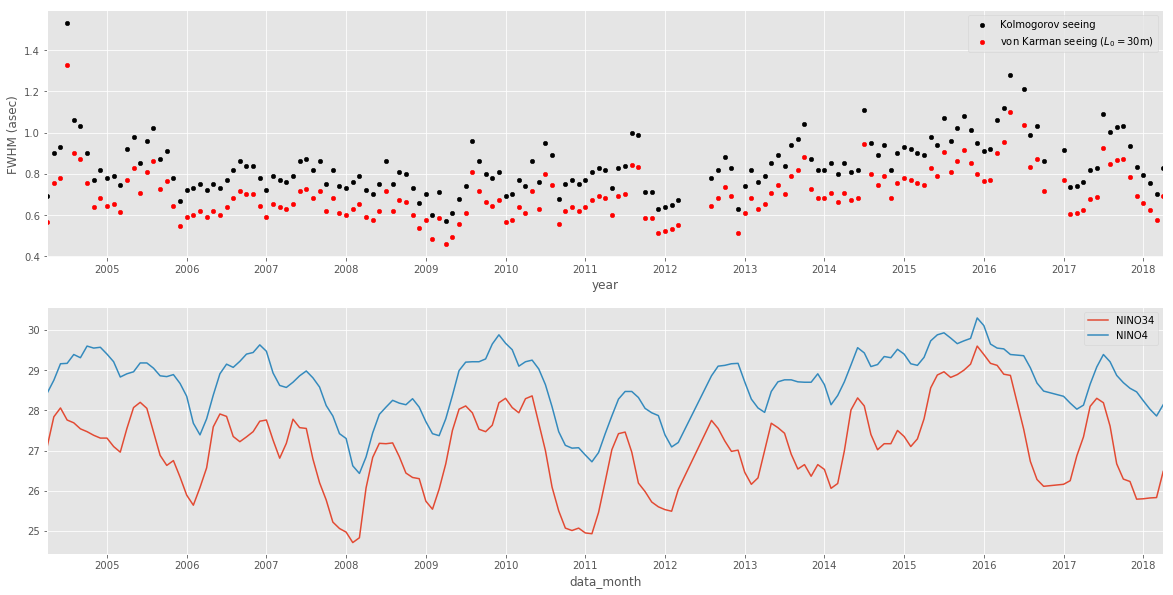

In [31]:
mpl.rcParams['figure.figsize'] = (20, 10)
fig, axes = plt.subplots(2)

df.plot.scatter('data_month', 'seeing', color='black', label='Kolmogorov seeing', ax=axes[0])
df.plot.scatter('data_month', 'vk_seeing', color='red', label='von Karman seeing ($L_0=30$m)', ax=axes[0])

#for k in ['NINO12', 'NINO3', 'NINO34', 'NINO4']:
for k in ['NINO34', 'NINO4']:
    df.plot('data_month', k, ax=axes[1])
    
# df.plot.scatter('data_month', 'NINO4', ax=axes[1])
                                  
month_ticks = np.arange(0, 180, 12)
for ax in axes:
    ax.set_xticks(month_ticks)
    ax.set_xticklabels(np.min(dimm.year) + (month_ticks/12).astype(int))
    ax.set_xlim(np.min(dimm.data_month), np.max(dimm.data_month))

axes[0].set_xlabel('year')
axes[0].set_ylabel('FWHM (asec)')

This is not convincing.

## Early LSST DIMM

In [143]:
lsst_2004_uncut = (pd.read_csv('/data/des70.a/data/neilsen/obs_strat/data/early_lsst/Pachon-dimm-nocut.dat.gz',
                           sep="\s+", header=None, names=('datestr', 'timestr', 'fwhm'),
                           parse_dates={'date':["datestr","timestr"]})
               .set_index('date')
               .tz_localize('UTC'))
lsst_2004_uncut['seeing'] = lsst_2004_uncut['fwhm']
lsst_2004_uncut['vk_seeing'] = calc_FWHM_vK(lsst_2004_uncut.seeing)
lsst_2004_uncut['month'] = lsst_2004_uncut.index.month
lsst_2004_uncut['year'] = lsst_2004_uncut.index.year
lsst_2004_uncut['data_month'] = 12*(lsst_2004_uncut.year - np.min(dimm.year)) + lsst_2004_uncut.month
lsst_2004_uncut['mjd'] = lsst_2004_uncut.index.to_julian_date() - 2400000.5
lsst_2004_uncut['night'] = np.floor(lsst_2004_uncut.mjd + ctio_night_shift).astype(int)
lsst_2004_uncut

/data/des70.a/data/neilsen/anaconda/envs/ehn37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


,fwhm,seeing,vk_seeing,month,year,data_month,mjd,night
date,,,,,,,,
2004-05-06 22:47:26+00:00,1.74,1.74,1.520723,5,2004,5,53131.949606,53132
2004-05-06 22:48:36+00:00,1.40,1.40,1.208253,5,2004,5,53131.950417,53132
2004-05-06 22:49:46+00:00,1.40,1.40,1.208253,5,2004,5,53131.951227,53132
2004-05-06 22:50:56+00:00,1.35,1.35,1.162498,5,2004,5,53131.952037,53132
2004-05-06 22:52:06+00:00,1.27,1.27,1.089410,5,2004,5,53131.952847,53132
...,...,...,...,...,...,...,...,...
2006-01-20 08:44:56+00:00,0.72,0.72,0.592276,1,2006,25,53755.364537,53755
2006-01-20 08:46:09+00:00,0.75,0.75,0.619077,1,2006,25,53755.365382,53755
2006-01-20 08:47:24+00:00,0.76,0.76,0.628021,1,2006,25,53755.366250,53755


In [78]:
lsst_2004 = (pd.read_csv('/data/des70.a/data/neilsen/obs_strat/data/early_lsst/Pachon-dimm-cut.dat.gz',
                           sep="\s+", header=None, names=('datestr', 'timestr', 'fwhm'),
                           parse_dates={'date':["datestr","timestr"]})
               .set_index('date')
               .tz_localize('UTC'))
lsst_2004['seeing'] = lsst_2004['fwhm']
lsst_2004['vk_seeing'] = calc_FWHM_vK(lsst_2004.seeing)
lsst_2004['month'] = lsst_2004.index.month
lsst_2004['year'] = lsst_2004.index.year
lsst_2004['data_month'] = 12*(lsst_2004.year - np.min(dimm.year)) + lsst_2004.month
lsst_2004['mjd'] = lsst_2004.index.to_julian_date() - 2400000.5
lsst_2004['night'] = np.floor(lsst_2004.mjd + ctio_night_shift).astype(int)
lsst_2004

,fwhm,seeing,vk_seeing,month,year,data_month,mjd,night
date,,,,,,,,
2004-05-06 22:47:26+00:00,1.74,1.74,1.451294,5,2004,5,53131.949606,53132
2004-05-06 22:48:36+00:00,1.40,1.40,1.146971,5,2004,5,53131.950417,53132
2004-05-06 22:49:46+00:00,1.40,1.40,1.146971,5,2004,5,53131.951227,53132
2004-05-06 22:50:56+00:00,1.35,1.35,1.102472,5,2004,5,53131.952037,53132
2004-05-06 22:52:06+00:00,1.27,1.27,1.031430,5,2004,5,53131.952847,53132
...,...,...,...,...,...,...,...,...
2006-01-20 08:44:56+00:00,0.72,0.72,0.549927,1,2006,25,53755.364537,53755
2006-01-20 08:46:09+00:00,0.75,0.75,0.575784,1,2006,25,53755.365382,53755
2006-01-20 08:47:24+00:00,0.76,0.76,0.584417,1,2006,25,53755.366250,53755


In [80]:
lsst_2002 = (pd.read_csv('/data/des70.a/data/neilsen/obs_strat/data/early_lsst/seeing0201-0402.txt.gz', sep="\t", parse_dates=['date'])
             .set_index('date')
             .tz_localize('UTC')
            )
lsst_2002['month'] = lsst_2002.index.month
lsst_2002

,HR,name,secz,nimg,fwhmx,fwhm,fwhmy,r0,meanflux,meandx,meandy,strehl_st1,strehl_st2,scstr1t1,scstr1t2,scstr2t1,scst2t2,month
date,,,,,,,,,,,,,,,,,,
2002-01-09 00:50:47+00:00,1956,ACol,1.15,170,1.66,1.62,1.58,6.18,25431,81.5,0.2,0.00,0.00,4.31,3.93,3.58,4.22,1
2002-01-09 00:51:49+00:00,1956,ACol,1.15,139,1.21,1.51,1.81,6.62,23562,81.5,0.2,0.00,0.00,4.57,3.71,4.49,3.86,1
2002-01-09 00:52:51+00:00,1956,ACol,1.14,78,1.41,1.56,1.72,6.39,22687,81.3,0.3,0.00,0.00,4.88,3.35,3.07,2.97,1
2002-01-09 00:54:26+00:00,1956,ACol,1.14,125,1.33,1.37,1.42,7.28,21460,81.7,0.1,0.00,0.00,5.25,4.20,4.98,4.16,1
2002-01-09 00:55:28+00:00,1956,ACol,1.14,160,1.48,1.57,1.65,6.38,21664,81.9,0.0,0.00,0.00,5.85,3.15,5.87,3.40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-01-31 09:26:26+00:00,4656,DCru,1.16,159,0.83,0.84,0.85,11.92,67370,89.7,0.6,0.23,0.45,0.50,0.82,0.68,0.88,1
2004-01-31 09:27:36+00:00,4656,DCru,1.17,163,0.89,0.86,0.84,11.59,66347,89.9,0.6,0.18,0.35,0.52,0.85,0.63,0.73,1
2004-01-31 09:28:48+00:00,4656,DCru,1.17,169,0.89,0.81,0.73,12.29,67679,89.7,0.6,0.21,0.49,0.47,0.86,0.66,0.87,1


In [81]:
lsst_2002['seeing'] = lsst_2002['fwhm']
lsst_2002['vk_seeing'] = calc_FWHM_vK(lsst_2002.seeing)
lsst_2002['double_vk'] = calc_FWHM_vK(lsst_2002.vk_seeing)
lsst_2002['month'] = lsst_2002.index.month
lsst_2002['year'] = lsst_2002.index.year
lsst_2002['data_month'] = 12*(lsst_2002.year - np.min(dimm.year)) + lsst_2002.month
lsst_2002['mjd'] = lsst_2002.index.to_julian_date() - 2400000.5
lsst_2002['night'] = np.floor(lsst_2002.mjd + ctio_night_shift).astype(int)

/data/des70.a/data/neilsen/anaconda/envs/ehn37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
pd.DataFrame([lsst_2002.r0.describe(), (100*dimm.r0).describe()])

,count,mean,std,min,25%,50%,75%,max
r0,201154.0,10.437363,4.864484,0.01000,7.860000,10.040000,12.460000,620.110000
r0,1160434.0,12.862406,4.293256,2.03893,9.918524,12.477748,15.313599,100.069064


In [36]:
myr0 = 0.98*5e-7/np.radians(lsst_2002.fwhm/(60*60))
((myr0-(lsst_2002.r0/100))/myr0).describe()

count    201154.000000
mean          0.010574
std           0.003729
min          -0.573557
25%           0.008289
50%           0.010584
75%           0.012900
max           0.191113
dtype: float64

In [37]:
dimm.seeing.describe()

count    1.160434e+06
mean     8.834132e-01
std      3.431807e-01
min      1.010000e-01
25%      6.600000e-01
50%      8.100000e-01
75%      1.019000e+00
max      4.957000e+00
Name: seeing, dtype: float64

/data/des70.a/data/neilsen/anaconda/envs/ehn37/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f8b848f4d68> has a label of '_no_label_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/data/des70.a/data/neilsen/anaconda/envs/ehn37/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f8b84923400> has a label of '_no_label_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


Text(0, 0.5, 'FWHM (asec)')

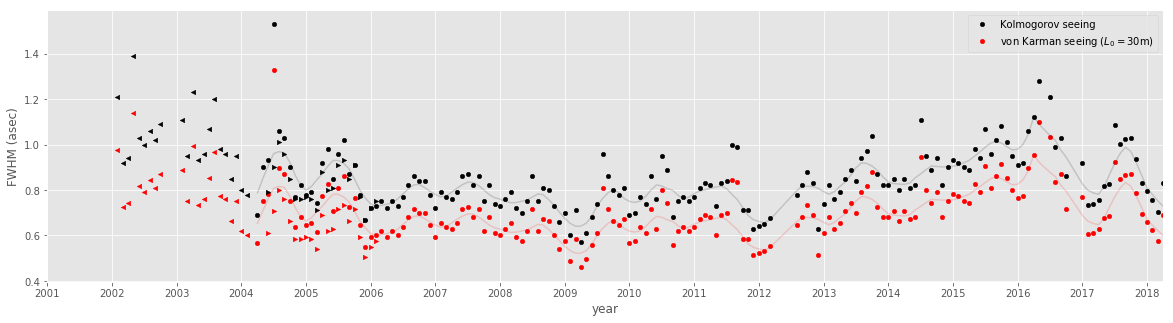

In [38]:
mpl.rcParams['figure.figsize'] = (20, 5)
fig, axes = plt.subplots()

df = dimm.groupby('data_month').agg({'seeing': 'median', 'vk_seeing': 'median'}).reset_index()
df.plot.scatter('data_month', 'seeing', color='black', label='Kolmogorov seeing', ax=axes)
df.plot.scatter('data_month', 'vk_seeing', color='red', label='von Karman seeing ($L_0=30$m)', ax=axes)

df['seeing_lowess'] = lowess(df.seeing, df.data_month, frac=0.05).T[1]
df.plot('data_month', 'seeing_lowess', color='black', alpha=0.15, label='_no_label_', ax=axes)
df['vk_seeing_lowess'] = lowess(df.vk_seeing, df.data_month, frac=0.05).T[1]
df.plot('data_month', 'vk_seeing_lowess', color='red', alpha=0.15, label='_no_label_', ax=axes)

lsst_df = lsst_2002.groupby('data_month').agg({'seeing': 'median', 'vk_seeing': 'median', 'double_vk': 'median'}).reset_index()
lsst_df.plot.scatter('data_month', 'seeing', color='black', marker='<', ax=axes)
lsst_df.plot.scatter('data_month', 'vk_seeing', color='red', marker='<', ax=axes)
#lsst_df.plot.scatter('data_month', 'double_vk', color='green', marker='<', ax=axes)

lsst_df2 = lsst_2004.groupby('data_month').agg({'seeing': 'median', 'vk_seeing': 'median'}).reset_index()
lsst_df2.plot.scatter('data_month', 'seeing', color='black', marker='>', ax=axes)
lsst_df2.plot.scatter('data_month', 'vk_seeing', color='red', marker='>', ax=axes)


month_ticks = np.arange(-36, 180, 12)
axes.set_xticks(month_ticks)
axes.set_xticklabels(np.min(dimm.year) + (month_ticks/12).astype(int))
axes.set_xlabel('year')
axes.set_ylabel('FWHM (asec)')

In [39]:
opsim_seeingdb_fname = '/data/des70.a/data/neilsen/singularity/opsim4_fbs_py3-2018-07-11/home/opsim/repos/sims_seeingModel/data/seeing.db'

In [180]:
with sqlite3.connect(opsim_seeingdb_fname) as conn:
    opsim_seeingdb = pd.read_sql_query('SELECT * FROM Seeing', conn)
    opsim_seeingdb.index = pd.to_datetime('2020-01-01T00:00:00Z') + pd.to_timedelta(opsim_seeingdb.s_date, unit='s')
    opsim_seeingdb['month'] = opsim_seeingdb.index.month
    opsim_seeingdb['mjd'] = opsim_seeingdb.index.to_julian_date() - 2400000.5
    opsim_seeingdb['night'] = np.floor(opsim_seeingdb.mjd + ctio_night_shift).astype(int)
    opsim_seeingdb['vk_seeing'] = opsim_seeingdb.seeing

In [125]:
pd.DataFrame([
    opsim_seeingdb.groupby('month').median().seeing.describe(),
    lsst_2002.groupby('month').median().vk_seeing.describe(),
    lsst_2004.groupby('month').median().vk_seeing.describe(),
    lsst_2004_uncut.groupby('month').median().vk_seeing.describe(),
    dimm.query('5<=data_month<=25').groupby('month').median().vk_seeing.describe()
], index=['opsim', 'lsst_2002', 'lsst_2004', 'lsst_2004_uncut', 'dimm'])

,count,mean,std,min,25%,50%,75%,max
opsim,12.0,0.618483,0.045303,0.566408,0.578699,0.617421,0.656822,0.692340
lsst_2002,12.0,0.780366,0.082164,0.619010,0.745183,0.788937,0.832806,0.907619
lsst_2004,12.0,0.632957,0.079617,0.515549,0.577947,0.619010,0.692838,0.775798
lsst_2004_uncut,12.0,0.695843,0.121471,0.532723,0.587659,0.714627,0.777987,0.916439
dimm,12.0,0.735699,0.123888,0.574435,0.617959,0.758236,0.805603,0.970991


In [45]:
ss6_fname = '/data/des70.a/data/neilsen/obs_strat/data/simsee_pachon6.db'
ss7_fname = '/data/des70.a/data/neilsen/obs_strat/data/simsee_pachon7.db'

In [177]:
with sqlite3.connect(ss6_fname) as conn:
    ss6_seeingdb = pd.read_sql_query('SELECT * FROM Seeing', conn)
    ss6_seeingdb.index = pd.to_datetime('2020-01-01T00:00:00Z') + pd.to_timedelta(ss6_seeingdb.s_date, unit='s')
    ss6_seeingdb['month'] = ss6_seeingdb.index.month
    ss6_seeingdb['data_month'] = 12*(ss6_seeingdb.index.year - np.min(ss6_seeingdb.index.year.values)) + ss6_seeingdb.month
    ss6_seeingdb['mjd'] = ss6_seeingdb.index.to_julian_date() - 2400000.5
    ss6_seeingdb['night'] = np.floor(ss6_seeingdb.mjd + ctio_night_shift).astype(int)
    ss6_seeingdb['vk_seeing'] = ss6_seeingdb.seeing

In [178]:
ss6_seeingdb.head()

,seeingId,s_date,seeing,month,data_month,mjd,night,vk_seeing
s_date,,,,,,,,
2020-01-01 00:00:00+00:00,1,0,0.7378037,1,1,58849.0000000,58849,0.7378037
2020-01-01 00:05:00+00:00,2,300,0.6640336,1,1,58849.0034722,58849,0.6640336
2020-01-01 00:10:00+00:00,3,600,0.7056808,1,1,58849.0069444,58849,0.7056808
2020-01-01 00:15:00+00:00,4,900,0.5309916,1,1,58849.0104167,58849,0.5309916
2020-01-01 00:20:00+00:00,5,1200,0.4724552,1,1,58849.0138889,58849,0.4724552


In [179]:
with sqlite3.connect(ss7_fname) as conn:
    ss7_seeingdb = pd.read_sql_query('SELECT * FROM Seeing', conn)
    ss7_seeingdb.index = pd.to_datetime('2020-01-01T00:00:00Z') + pd.to_timedelta(ss7_seeingdb.s_date, unit='s') 
    ss7_seeingdb['month'] = ss7_seeingdb.index.month
    ss7_seeingdb['data_month'] = 12*(4+ ss7_seeingdb.index.year - np.min(ss7_seeingdb.index.year.values)) + ss7_seeingdb.month
    ss7_seeingdb['mjd'] = ss7_seeingdb.index.to_julian_date() - 2400000.5
    ss7_seeingdb['night'] = np.floor(ss7_seeingdb.mjd + ctio_night_shift).astype(int)
    ss7_seeingdb['vk_seeing'] = ss7_seeingdb.seeing

In [49]:
ss7_seeingdb.head()

,seeingId,s_date,seeing,month,data_month
s_date,,,,,
2020-01-01 00:00:00+00:00,1,0,0.780048,1,49
2020-01-01 00:05:00+00:00,2,300,0.734101,1,49
2020-01-01 00:10:00+00:00,3,600,0.636290,1,49
2020-01-01 00:15:00+00:00,4,900,0.616209,1,49
2020-01-01 00:20:00+00:00,5,1200,0.511734,1,49


In [50]:
%%script true

mpl.rcParams['figure.figsize'] = (13, 8)
fig, ax = plt.subplots()
def plot_seeing_kde(df, col='vk_seeing', **kwarg):
    df = df[df[col] < 2]
    df[col].plot.density(ax=ax)
    
plot_seeing_kde(opsim_seeingdb, 'seeing', label='opsim')
plot_seeing_kde(lsst_2002, label='2002')
plot_seeing_kde(lsst_2004, label='2004')
plot_seeing_kde(ss6_seeingdb, 'seeing', label='ss6')
plot_seeing_kde(ss7_seeingdb, 'seeing', label='ss7')
ax.set_xlim(0, 2)
ax.legend()

In [51]:
#dimm['data_month'] = 12*(raw_dimm.year - np.min(raw_dimm.year)) + raw_dimm.month
dimm.groupby('month')['vk_seeing', 'seeing'].median().loc[7]

vk_seeing    0.771757
seeing       0.920000
Name: 7, dtype: float64

In [52]:
dimm.groupby('data_month')['vk_seeing', 'seeing', 'month'].median().groupby('month').median().loc[7]

vk_seeing    0.803342
seeing       0.955000
Name: 7, dtype: float64

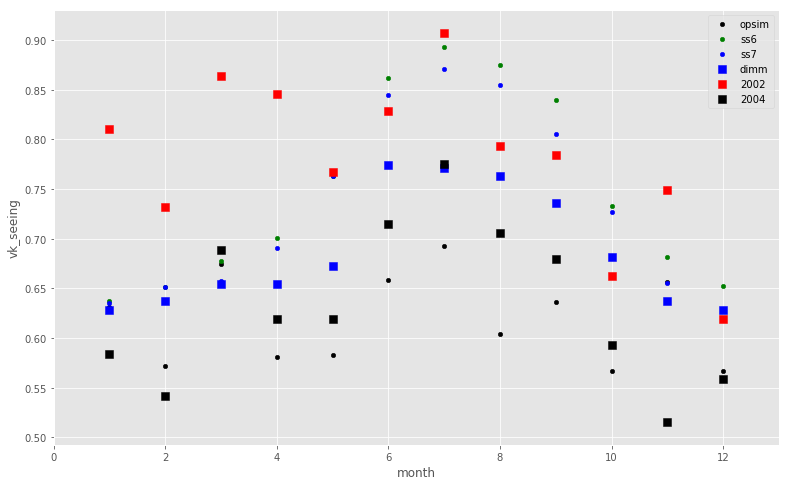

In [53]:
mpl.rcParams['figure.figsize'] = (13, 8)
fig, ax = plt.subplots()
opsim_seeingdb.groupby('month')['seeing'].median().reset_index().plot.scatter(
    'month', 'seeing', label='opsim', ax=ax, c='k')
ss6_seeingdb.groupby('month')['seeing'].median().reset_index().plot.scatter(
    'month', 'seeing', label='ss6', ax=ax, c='g')
ss7_seeingdb.groupby('month')['seeing'].median().reset_index().plot.scatter(
    'month', 'seeing', label='ss7', ax=ax, c='b')
dimm.groupby('month')['vk_seeing'].median().reset_index().plot.scatter(
    'month', 'vk_seeing', label='dimm', ax=ax, c='b', marker='s', s=50)
lsst_2002.groupby('month')['vk_seeing'].median().reset_index().plot.scatter(
    'month', 'vk_seeing', label='2002', ax=ax, c='r', marker='s', s=50)
lsst_2004.groupby('month')['vk_seeing'].median().reset_index().plot.scatter(
    'month', 'vk_seeing', label='2004', ax=ax, c='k', marker='s', s=50)
ax.set_xlim(0, 13)
ax.legend()

Text(0, 0.5, 'FWHM (asec)')

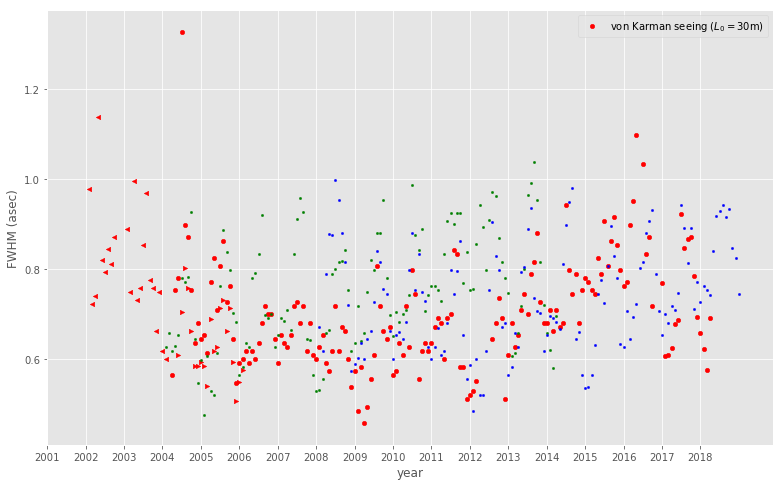

In [54]:
fig, axes = plt.subplots()

dimm_df = dimm.groupby('data_month').agg({'seeing': 'median', 'vk_seeing': 'median', 'month': 'median'}).reset_index()
#df.plot.scatter('data_month', 'seeing', color='black', label='Kolmogorov seeing', ax=axes)
dimm_df.plot.scatter('data_month', 'vk_seeing', color='red', label='von Karman seeing ($L_0=30$m)', ax=axes)

#df['seeing_lowess'] = lowess(df.seeing, df.data_month, frac=0.05).T[1]
#df.plot('data_month', 'seeing_lowess', color='black', alpha=0.15, label='_no_label_', ax=axes)
#df['vk_seeing_lowess'] = lowess(df.vk_seeing, df.data_month, frac=0.05).T[1]
#df.plot('data_month', 'vk_seeing_lowess', color='red', alpha=0.15, label='_no_label_', ax=axes)

lsst_df = lsst_2002.groupby('data_month').agg({'seeing': 'median', 'vk_seeing': 'median', 'month': 'median', 'double_vk': 'median'}).reset_index()
#lsst_df.plot.scatter('data_month', 'seeing', color='black', marker='<', ax=axes)
lsst_df.plot.scatter('data_month', 'vk_seeing', color='red', marker='<', ax=axes)

lsst_df2 = lsst_2004.groupby('data_month').agg({'seeing': 'median', 'vk_seeing': 'median'}).reset_index()
#lsst_df2.plot.scatter('data_month', 'seeing', color='black', marker='>', ax=axes)
lsst_df2.plot.scatter('data_month', 'vk_seeing', color='red', marker='>', ax=axes)

ss6_df = ss6_seeingdb.groupby('data_month').agg({'seeing': 'median', 'month': 'median'}).reset_index()
ss6_df.plot.scatter('data_month', 'seeing', color='green', marker='.', ax=axes)

ss7_df = ss7_seeingdb.groupby('data_month').agg({'seeing': 'median', 'month': 'median'}).reset_index()
ss7_df.plot.scatter('data_month', 'seeing', color='blue', marker='.', ax=axes)


month_ticks = np.arange(-36, 180, 12)
axes.set_xticks(month_ticks)
axes.set_xticklabels(np.min(dimm.year) + (month_ticks/12).astype(int))
axes.set_xlabel('year')
axes.set_ylabel('FWHM (asec)')

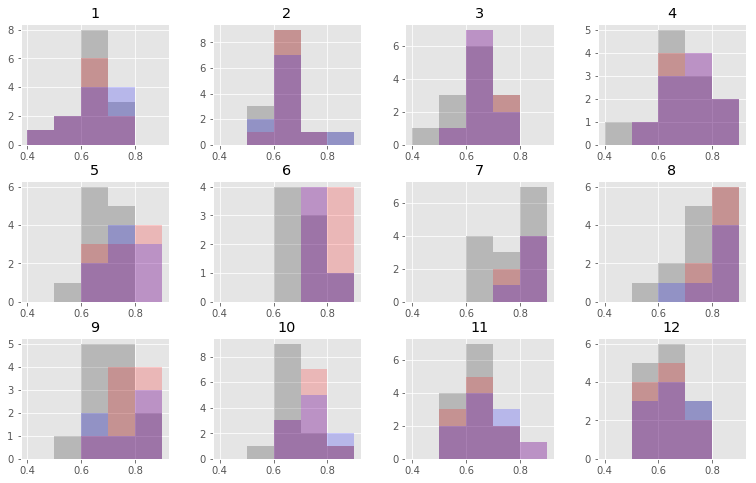

In [55]:
fig, axes = plt.subplots(3, 4)
bins=np.arange(0.4, 1, 0.1)
for idx, month in enumerate(np.arange(1, 13)):
    ax = axes.flatten()[idx]
    dimm_df.query(f'month=={month}').hist('vk_seeing', color='k', ax=ax, bins=bins, alpha=0.2)
    ss7_df.query(f'month=={month}').hist('seeing', color='r', ax=ax, bins=bins, alpha=0.2)
    ss6_df.query(f'month=={month}').hist('seeing', color='b', ax=ax, bins=bins, alpha=0.2)
    ax.set_title(f'{month}')

In [56]:
ss6_seeingdb.head()

,seeingId,s_date,seeing,month,data_month
s_date,,,,,
2020-01-01 00:00:00+00:00,1,0,0.737804,1,1
2020-01-01 00:05:00+00:00,2,300,0.664034,1,1
2020-01-01 00:10:00+00:00,3,600,0.705681,1,1
2020-01-01 00:15:00+00:00,4,900,0.530992,1,1
2020-01-01 00:20:00+00:00,5,1200,0.472455,1,1


In [57]:
ss6_seeingdb.s_date.dtype

dtype('int64')

In [58]:
ss6_idx = pd.to_datetime('2020-01-01T00:00:00Z') + pd.to_timedelta(ss6_seeingdb.s_date, unit='s') 
ss6_idx

s_date
2020-01-01 00:00:00+00:00   2020-01-01 00:00:00+00:00
2020-01-01 00:05:00+00:00   2020-01-01 00:05:00+00:00
2020-01-01 00:10:00+00:00   2020-01-01 00:10:00+00:00
2020-01-01 00:15:00+00:00   2020-01-01 00:15:00+00:00
2020-01-01 00:20:00+00:00   2020-01-01 00:20:00+00:00
                                       ...           
2030-03-20 10:01:24+00:00   2030-03-20 10:01:24+00:00
2030-03-20 10:02:27+00:00   2030-03-20 10:02:27+00:00
2030-03-20 10:03:30+00:00   2030-03-20 10:03:30+00:00
2030-03-20 10:04:34+00:00   2030-03-20 10:04:34+00:00
2030-03-20 10:05:17+00:00   2030-03-20 10:05:17+00:00
Name: s_date, Length: 1688676, dtype: datetime64[ns, UTC]

In [59]:
ss6_seeingdb.seeing.describe()

count    1.688676e+06
mean     7.975117e-01
std      3.391062e-01
min      2.794297e-02
25%      5.777768e-01
50%      7.293150e-01
75%      9.346503e-01
max      1.009671e+01
Name: seeing, dtype: float64

In [60]:
ss7_seeingdb.seeing.describe()

count    1.857227e+06
mean     7.827963e-01
std      3.219010e-01
min      2.794297e-02
25%      5.655237e-01
50%      7.177253e-01
75%      9.182498e-01
max      4.881831e+00
Name: seeing, dtype: float64

In [61]:
dimm.vk_seeing.describe()

count    1.160434e+06
mean     7.408255e-01
std      3.116583e-01
min      5.970229e-02
25%      5.388234e-01
50%      6.728152e-01
75%      8.612115e-01
max      4.535901e+00
Name: vk_seeing, dtype: float64

In [62]:
ss6_seeingdb.query('seeingId==2569')

/data/des70.a/data/neilsen/anaconda/envs/ehn37/lib/python3.7/site-packages/pandas/core/generic.py:407: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  s = level_values.to_series()
/data/des70.a/data/neilsen/anaconda/envs/ehn37/lib/python3.7/site-packages/pandas/core/generic.py:415: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  dindex = axis_index.to_series()


,seeingId,s_date,seeing,month,data_month
s_date,,,,,
2020-01-05 08:10:34+00:00,2569,375034,0.538823,1,1


In [63]:
ss6_seeingdb.query('seeingId==2640')

,seeingId,s_date,seeing,month,data_month
s_date,,,,,
2020-01-05 11:52:17+00:00,2640,388337,0.360897,1,1


In [64]:
ss6_seeingdb.head(15).tail(10)

,seeingId,s_date,seeing,month,data_month
s_date,,,,,
2020-01-01 00:25:00+00:00,6,1500,0.412879,1,1
2020-01-01 00:30:00+00:00,7,1800,0.563043,1,1
2020-01-01 00:35:00+00:00,8,2100,0.574244,1,1
2020-01-01 00:42:49+00:00,9,2569,0.485592,1,1
2020-01-01 00:44:00+00:00,10,2640,0.441422,1,1
2020-01-01 00:45:11+00:00,11,2711,0.476743,1,1
2020-01-01 00:46:22+00:00,12,2782,0.583353,1,1
2020-01-01 00:47:33+00:00,13,2853,0.547718,1,1
2020-01-01 00:48:44+00:00,14,2924,0.592276,1,1


In [65]:
dimm.index[0]

Timestamp('2004-03-17 02:33:15')

In [66]:
# seeingid 9
s = dimm.loc[pd.Timestamp('2008-01-02T00:42:49')]
s

seeing            0.600000
r0                0.168450
log_r0           -0.773530
vk_seeing         0.485592
month             1.000000
year           2008.000000
data_month       49.000000
mjd           54467.029734
night         54467.000000
Name: 2008-01-02 00:42:49, dtype: float64

In [67]:
dimm.index.month


Int64Index([3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
            ...
            3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
           dtype='int64', name='time', length=1160434)

In [68]:
ss6_seeingdb.tail()

,seeingId,s_date,seeing,month,data_month
s_date,,,,,
2030-03-20 10:01:24+00:00,1688672,322394484,0.578893,3,123
2030-03-20 10:02:27+00:00,1688673,322394547,0.572653,3,123
2030-03-20 10:03:30+00:00,1688674,322394610,0.584245,3,123
2030-03-20 10:04:34+00:00,1688675,322394674,0.593168,3,123
2030-03-20 10:05:17+00:00,1688676,322394717,0.632047,3,123


In [69]:
dimm.query('abs(vk_seeing-0.632047)<0.000001')

,seeing,r0,log_r0,vk_seeing,month,year,data_month,mjd,night
time,,,,,,,,,
2018-03-21 10:05:17,0.7645,0.132204,-0.878756,0.632047,3,2018,171,58198.420336,58198


In [70]:
dimm.describe().T

,count,mean,std,min,25%,50%,75%,max
seeing,1160434.0,0.883413,0.343181,0.101000,0.660000,0.810000,1.019000,4.957000
r0,1160434.0,0.128624,0.042933,0.020389,0.099185,0.124777,0.153136,1.000691
log_r0,1160434.0,-0.914833,0.148007,-1.690598,-1.003553,-0.903864,-0.814923,0.000300
vk_seeing,1160434.0,0.740825,0.311658,0.059702,0.538823,0.672815,0.861211,4.535901
month,1160434.0,6.258008,3.631205,1.000000,3.000000,6.000000,10.000000,12.000000
year,1160434.0,2010.499858,4.146830,2004.000000,2007.000000,2010.000000,2014.000000,2018.000000
data_month,1160434.0,84.256302,49.470111,3.000000,41.000000,76.000000,127.000000,171.000000
mjd,1160434.0,55553.614196,1505.468483,53081.106424,54233.174337,55316.193038,56855.021001,58198.420336
night,1160434.0,55553.418956,1505.469621,53081.000000,54233.000000,55316.000000,56855.000000,58198.000000


In [71]:
dimm.head()

,seeing,r0,log_r0,vk_seeing,month,year,data_month,mjd,night
time,,,,,,,,,
2004-03-17 02:33:15,0.71,0.142352,-0.846637,0.583353,3,2004,3,53081.106424,53081
2004-03-17 02:34:35,0.74,0.136581,-0.864611,0.610138,3,2004,3,53081.107350,53081
2004-03-17 02:35:42,0.74,0.136581,-0.864611,0.610138,3,2004,3,53081.108125,53081
2004-03-17 02:36:49,0.75,0.134760,-0.870440,0.619077,3,2004,3,53081.108900,53081
2004-03-17 02:37:58,0.72,0.140375,-0.852711,0.592276,3,2004,3,53081.109699,53081


In [82]:
lsst_2004.head()

,fwhm,seeing,vk_seeing,month,year,data_month,mjd,night
date,,,,,,,,
2004-05-06 22:47:26+00:00,1.74,1.74,1.451294,5,2004,5,53131.949606,53132
2004-05-06 22:48:36+00:00,1.40,1.40,1.146971,5,2004,5,53131.950417,53132
2004-05-06 22:49:46+00:00,1.40,1.40,1.146971,5,2004,5,53131.951227,53132
2004-05-06 22:50:56+00:00,1.35,1.35,1.102472,5,2004,5,53131.952037,53132
2004-05-06 22:52:06+00:00,1.27,1.27,1.031430,5,2004,5,53131.952847,53132


In [74]:
dimm.head()

,seeing,r0,log_r0,vk_seeing,month,year,data_month,mjd,night
time,,,,,,,,,
2004-03-17 02:33:15,0.71,0.142352,-0.846637,0.583353,3,2004,3,53081.106424,53081
2004-03-17 02:34:35,0.74,0.136581,-0.864611,0.610138,3,2004,3,53081.107350,53081
2004-03-17 02:35:42,0.74,0.136581,-0.864611,0.610138,3,2004,3,53081.108125,53081
2004-03-17 02:36:49,0.75,0.134760,-0.870440,0.619077,3,2004,3,53081.108900,53081
2004-03-17 02:37:58,0.72,0.140375,-0.852711,0.592276,3,2004,3,53081.109699,53081


In [108]:
bynight = dimm.groupby('night').mean().merge(lsst_2004_uncut.groupby('night').mean(), right_index=True, left_index=True, suffixes=('_dimm', '_lsst'))
bynight.head()

,seeing_dimm,r0,log_r0,vk_seeing_dimm,month_dimm,year_dimm,data_month_dimm,mjd_dimm,fwhm,seeing_lsst,vk_seeing_lsst,month_lsst,year_lsst,data_month_lsst,mjd_lsst
night,,,,,,,,,,,,,,,
53132,1.280086,0.084734,-1.086600,1.100141,5.0,2004.0,5.0,53132.193723,1.280086,1.280086,1.042352,5.0,2004.0,5.0,53132.193723
53133,0.716268,0.148774,-0.838849,0.589693,5.0,2004.0,5.0,53133.187146,0.716268,0.716268,0.547674,5.0,2004.0,5.0,53133.187146
53134,0.750362,0.138391,-0.864803,0.619787,5.0,2004.0,5.0,53134.175977,0.750362,0.750362,0.576593,5.0,2004.0,5.0,53134.175977
53135,1.159077,0.090380,-1.051739,0.989020,5.0,2004.0,5.0,53135.139056,1.159077,1.159077,0.934156,5.0,2004.0,5.0,53135.139056
53136,1.940000,0.057049,-1.263981,1.707705,5.0,2004.0,5.0,53136.036539,1.940000,1.940000,1.634430,5.0,2004.0,5.0,53136.036539


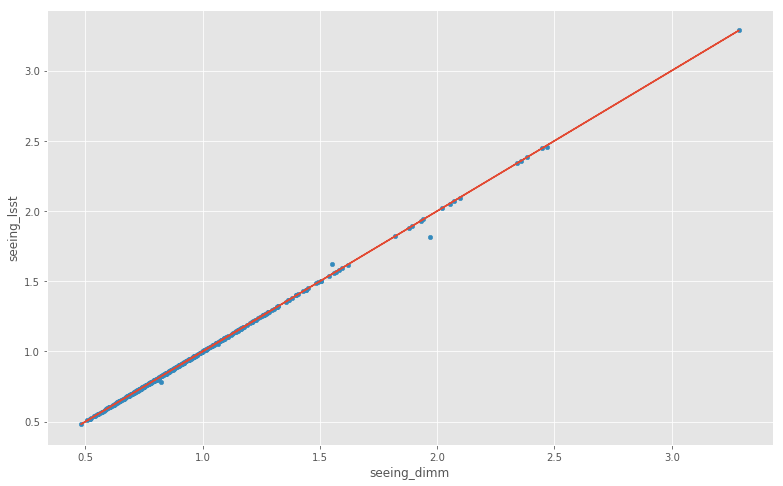

In [109]:
ax = bynight.plot.scatter('seeing_dimm', 'seeing_lsst')
ax.plot(bynight.seeing_dimm, bynight.seeing_dimm)

In [100]:
by5min = pd.DataFrame({'dimm': dimm.tz_localize('UTC').loc[:lsst_2004.index.max(), 'seeing'].resample('5T').asfreq(),
                       'lsst': lsst_2004.seeing.resample('5T').asfreq()})
by5min.describe()

,dimm,lsst
count,486.000000,280.000000
mean,0.904959,0.823929
std,0.336310,0.235437
min,0.400000,0.410000
25%,0.680000,0.647500
50%,0.830000,0.790000
75%,1.067500,0.980000
max,2.870000,1.720000


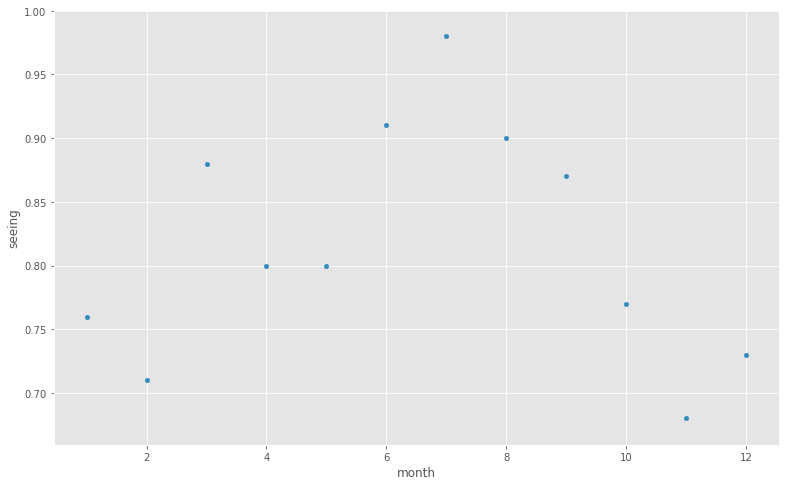

In [118]:
lsst_2004.groupby('month').median().reset_index().plot.scatter('month', 'seeing')

In [104]:
dimm.loc['2004-05-06 22:47:26']

seeing            1.740000
r0                0.058086
log_r0           -1.235928
vk_seeing         1.520723
month             5.000000
year           2004.000000
data_month        5.000000
mjd           53131.949606
night         53132.000000
Name: 2004-05-06 22:47:26, dtype: float64

In [126]:
lsst_2004

,fwhm,seeing,vk_seeing,month,year,data_month,mjd,night
date,,,,,,,,
2004-05-06 22:47:26+00:00,1.74,1.74,1.451294,5,2004,5,53131.949606,53132
2004-05-06 22:48:36+00:00,1.40,1.40,1.146971,5,2004,5,53131.950417,53132
2004-05-06 22:49:46+00:00,1.40,1.40,1.146971,5,2004,5,53131.951227,53132
2004-05-06 22:50:56+00:00,1.35,1.35,1.102472,5,2004,5,53131.952037,53132
2004-05-06 22:52:06+00:00,1.27,1.27,1.031430,5,2004,5,53131.952847,53132
...,...,...,...,...,...,...,...,...
2006-01-20 08:44:56+00:00,0.72,0.72,0.549927,1,2006,25,53755.364537,53755
2006-01-20 08:46:09+00:00,0.75,0.75,0.575784,1,2006,25,53755.365382,53755
2006-01-20 08:47:24+00:00,0.76,0.76,0.584417,1,2006,25,53755.366250,53755


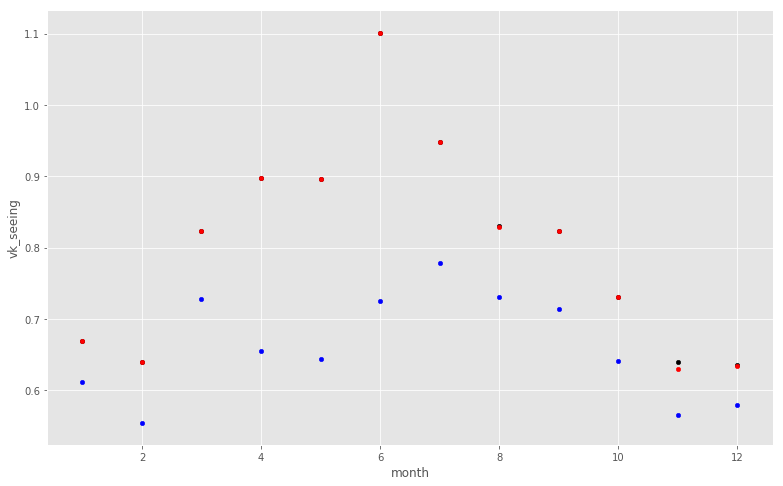

In [144]:
dimm_uncut_overlap = dimm[lsst_2004_uncut.index.values[0]:lsst_2004_uncut.index.values[-1]]
ax = dimm_uncut_overlap.groupby('month').mean().reset_index().plot.scatter('month', 'vk_seeing', c='k')
lsst_2004_uncut.groupby('month').mean().reset_index().plot.scatter('month', 'vk_seeing', c='r', ax=ax)
lsst_2004.groupby('month').mean().reset_index().plot.scatter('month', 'vk_seeing', c='b', ax=ax)

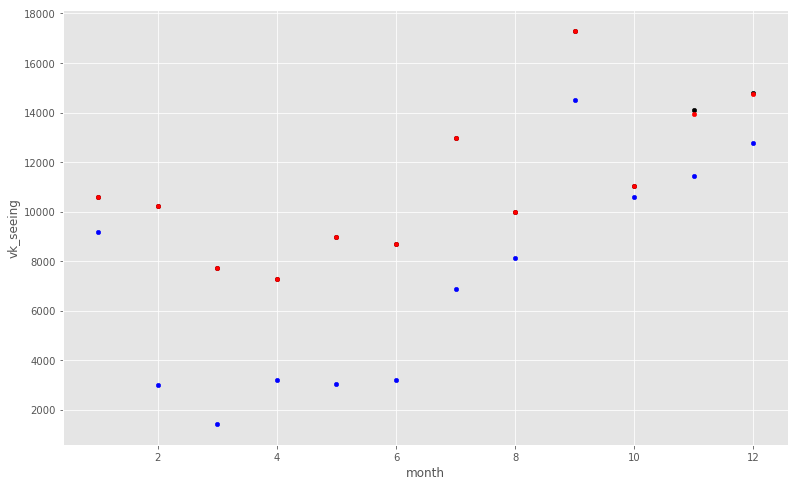

In [145]:
dimm_uncut_overlap = dimm[lsst_2004_uncut.index.values[0]:lsst_2004_uncut.index.values[-1]]
ax = dimm_uncut_overlap.groupby('month').count().reset_index().plot.scatter('month', 'vk_seeing', c='k')
lsst_2004_uncut.groupby('month').count().reset_index().plot.scatter('month', 'vk_seeing', c='r', ax=ax)
lsst_2004.groupby('month').count().reset_index().plot.scatter('month', 'vk_seeing', c='b', ax=ax)

In [146]:
dimm_uncut_overlap.head()

,seeing,r0,log_r0,vk_seeing,month,year,data_month,mjd,night
time,,,,,,,,,
2004-05-06 22:47:26,1.74,0.058086,-1.235928,1.520723,5,2004,5,53131.949606,53132
2004-05-06 22:48:36,1.40,0.072193,-1.141507,1.208253,5,2004,5,53131.950417,53132
2004-05-06 22:49:46,1.40,0.072193,-1.141507,1.208253,5,2004,5,53131.951227,53132
2004-05-06 22:50:56,1.35,0.074866,-1.125713,1.162498,5,2004,5,53131.952037,53132
2004-05-06 22:52:06,1.27,0.079582,-1.099183,1.089410,5,2004,5,53131.952847,53132


In [147]:
lsst_2004_uncut.head()

,fwhm,seeing,vk_seeing,month,year,data_month,mjd,night
date,,,,,,,,
2004-05-06 22:47:26+00:00,1.74,1.74,1.520723,5,2004,5,53131.949606,53132
2004-05-06 22:48:36+00:00,1.40,1.40,1.208253,5,2004,5,53131.950417,53132
2004-05-06 22:49:46+00:00,1.40,1.40,1.208253,5,2004,5,53131.951227,53132
2004-05-06 22:50:56+00:00,1.35,1.35,1.162498,5,2004,5,53131.952037,53132
2004-05-06 22:52:06+00:00,1.27,1.27,1.089410,5,2004,5,53131.952847,53132


In [246]:
pd.set_option('display.precision', 7)
dfs = OrderedDict((
    ('Claver seeing0201-0402.txt.gz', lsst_2002),
    ('Claver Pachon-dimm-nocut.dat.gz', lsst_2004_uncut),
    ('Claver Pachon-dimm-cut.dat.gz', lsst_2004),
    ('Bustos pachon.Pachon_seeing-2004-2016.txt.bz2 + PachonSM.DIMM-2016-2018.txt.bz2', dimm),
    ('opsim seeing.db', opsim_seeingdb),
    ('simsee_pachon6.db', ss6_seeingdb),
    ('simsee_pachon7.db', ss6_seeingdb)
))

src_stats = pd.DataFrame([dfs[k].groupby('night').agg({'vk_seeing': 'median', 'month': 'count'}).query('month > 100').vk_seeing.describe() for k in dfs.keys()],
                          index = dfs.keys())
src_stats.index.name = 'source'
src_stats['start_date'] = [dfs[k].index.min().date() for k in dfs.keys()]
src_stats['end_date'] = [dfs[k].index.max().date() for k in dfs.keys()]
src_stats = src_stats[['start_date', 'end_date', 'min', '25%', '50%', 'mean', '75%', 'max']]
with pd.option_context('display.precision', 2, 'display.width', 512):
    print(src_stats.iloc[:5])

                                                    start_date    end_date   min   25%   50%  mean   75%   max
source                                                                                                        
Claver seeing0201-0402.txt.gz                       2002-01-09  2004-01-31  0.35  0.65  0.79  0.86  0.97  2.96
Claver Pachon-dimm-nocut.dat.gz                     2004-05-06  2006-01-20  0.37  0.57  0.70  0.76  0.88  3.11
Claver Pachon-dimm-cut.dat.gz                       2004-05-06  2006-01-20  0.34  0.52  0.60  0.64  0.71  1.68
Bustos pachon.Pachon_seeing-2004-2016.txt.bz2 +...  2004-03-17  2018-03-21  0.23  0.57  0.66  0.72  0.82  3.11
opsim seeing.db                                     2020-01-01  2021-12-31  0.20  0.54  0.62  0.63  0.71  1.18


In [245]:
pd.set_option('display.precision', 7)
dfs = OrderedDict((
    ('Claver seeing0201-0402.txt.gz', lsst_2002),
    ('Claver Pachon-dimm-nocut.dat.gz', lsst_2004_uncut),
    ('Claver Pachon-dimm-cut.dat.gz', lsst_2004),
    ('Bustos pachon.Pachon_seeing-2004-2016.txt.bz2 + PachonSM.DIMM-2016-2018.txt.bz2', dimm),
    ('opsim seeing.db', opsim_seeingdb),
    ('simsee_pachon6.db', ss6_seeingdb),
    ('simsee_pachon7.db', ss6_seeingdb)
))

src_stats = pd.DataFrame([dfs[k].groupby('month').agg({'vk_seeing': 'median', 'month': 'count'}).query('month > 100').vk_seeing.describe() for k in dfs.keys()],
                          index = dfs.keys())
src_stats.index.name = 'source'
src_stats['start_date'] = [dfs[k].index.min().date() for k in dfs.keys()]
src_stats['end_date'] = [dfs[k].index.max().date() for k in dfs.keys()]
src_stats = src_stats[['start_date', 'end_date', 'min', '25%', '50%', 'mean', '75%', 'max']]
with pd.option_context('display.precision', 2, 'display.width', 512):
    print(src_stats.iloc[:5])

                                                    start_date    end_date   min   25%   50%  mean   75%   max
source                                                                                                        
Claver seeing0201-0402.txt.gz                       2002-01-09  2004-01-31  0.62  0.75  0.79  0.78  0.83  0.91
Claver Pachon-dimm-nocut.dat.gz                     2004-05-06  2006-01-20  0.57  0.63  0.76  0.74  0.83  0.97
Claver Pachon-dimm-cut.dat.gz                       2004-05-06  2006-01-20  0.52  0.58  0.62  0.63  0.69  0.78
Bustos pachon.Pachon_seeing-2004-2016.txt.bz2 +...  2004-03-17  2018-03-21  0.63  0.64  0.66  0.69  0.74  0.77
opsim seeing.db                                     2020-01-01  2021-12-31  0.57  0.58  0.62  0.62  0.66  0.69


In [252]:
dfs = OrderedDict((
    ('Claver Pachon-dimm-nocut.dat.gz', lsst_2004_uncut),
    ('Claver Pachon-dimm-cut.dat.gz', lsst_2004)
))
cut_stats = pd.DataFrame({'cut': lsst_2004.groupby('month')['night'].count(),
                          'uncut': lsst_2004_uncut.groupby('month')['night'].count()})
cut_stats['fraction'] = (cut_stats.uncut-cut_stats.cut)/cut_stats.uncut
cut_stats['dimm_median'] = dimm.groupby('month')['vk_seeing'].median()
with pd.option_context('display.precision', 2, 'display.width', 512, 'display.max_rows', 13):
    print(cut_stats[['fraction', 'uncut', 'dimm_median']])

       fraction  uncut  dimm_median
month                              
1          0.13  10595         0.63
2          0.71  10212         0.64
3          0.81   7713         0.65
4          0.56   7263         0.65
5          0.66   8971         0.67
6          0.63   8677         0.77
7          0.47  12973         0.77
8          0.19   9987         0.76
9          0.16  17288         0.74
10         0.04  11040         0.68
11         0.18  13949         0.64
12         0.14  14760         0.63


In [257]:
with pd.option_context('display.precision', 2, 'display.width', 512, 'display.max_rows', 13):
    print(dimm.groupby('month')['vk_seeing'].median())

month
1     0.63
2     0.64
3     0.65
4     0.65
5     0.67
6     0.77
7     0.77
8     0.76
9     0.74
10    0.68
11    0.64
12    0.63
Name: vk_seeing, dtype: float64


In [258]:
0.85+0.5+0.5

1.85

In [265]:
lsst_2002.columns

Index(['HR', 'name', 'secz', 'nimg', 'fwhmx', 'fwhm', 'fwhmy', 'r0',
       'meanflux', 'meandx', 'meandy', 'strehl_st1', 'strehl_st2', 'scstr1t1',
       'scstr1t2', 'scstr2t1', 'scst2t2', 'month', 'seeing', 'vk_seeing',
       'double_vk', 'year', 'data_month', 'mjd', 'night'],
      dtype='object')

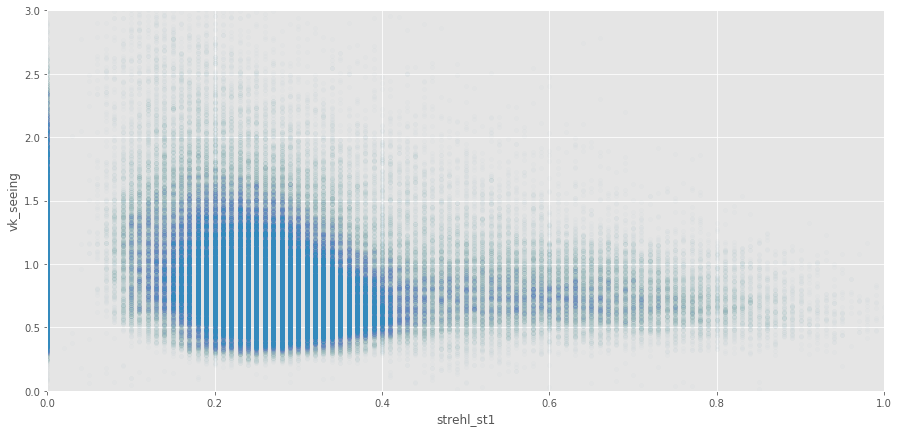

In [269]:
lsst_2002.plot.scatter('strehl_st1', 'vk_seeing', xlim=(0, 1), ylim=(0, 3), alpha=0.01)

/data/des70.a/data/neilsen/anaconda/envs/ehn37/lib/python3.7/site-packages/pandas/core/generic.py:407: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  s = level_values.to_series()
/data/des70.a/data/neilsen/anaconda/envs/ehn37/lib/python3.7/site-packages/pandas/core/generic.py:415: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  dindex = axis_index.to_series()


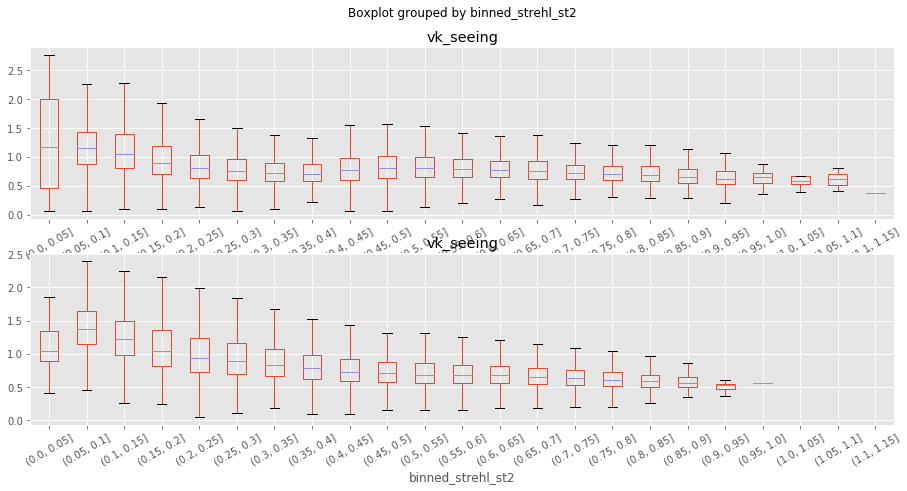

In [291]:
fig, axes = plt.subplots(2)
df = lsst_2002.query('vk_seeing < 3').copy()
df['binned_strehl_st1'] = pd.cut(df['strehl_st1'], np.arange(0, 1.2, 0.05))
df['binned_strehl_st2'] = pd.cut(df['strehl_st2'], np.arange(0, 1.2, 0.05))
df.boxplot('vk_seeing', by='binned_strehl_st1', showfliers=False, ax=axes[0])
axes[0].tick_params(axis='x', labelrotation=30)
df.boxplot('vk_seeing', by='binned_strehl_st2', showfliers=False, ax=axes[1])
axes[1].tick_params(axis='x', labelrotation=30)